In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from diproperm.DiProPerm import DiProPerm

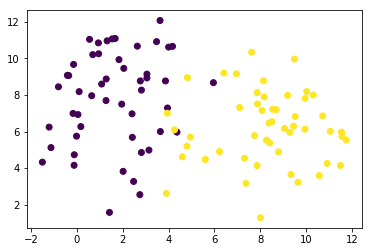

In [2]:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=2, random_state=20)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [3]:
# fit DiProPerm using mean difference classifier
# compute md, t and auc summary statistics
# sample 1000 permutations
dpp = DiProPerm(B=1000, separation_stats=['md', 't', 'auc'], clf='md')
dpp.fit(X, y)

Two class DiProPerm

In [4]:
# the results are stored in dpp.test_stats_[STAT] where STAT is the desired summary statistic
print('DiProPerm using md statistic')
print(dpp.test_stats_['md'])

print('\nDiProPerm using t statistic')
print(dpp.test_stats_['t'])

print('\nDiProPerm using auc statistic')
print(dpp.test_stats_['auc'])

DiProPerm using md statistic
{'obs': 6.811364163879698, 'pval': 0.0, 'rejected': True, 'cutoff_val': 6.806899017717695, 'Z': 0.9116976467836664}

DiProPerm using t statistic
{'obs': 18.033513549658647, 'pval': 0.015, 'rejected': True, 'cutoff_val': 18.01534541814688, 'Z': 0.9970240917991013}

DiProPerm using auc statistic
{'obs': 0.996, 'pval': 0.018, 'rejected': True, 'cutoff_val': 0.996, 'Z': 1.1394287502694687}


/Users/iaincarmichael/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


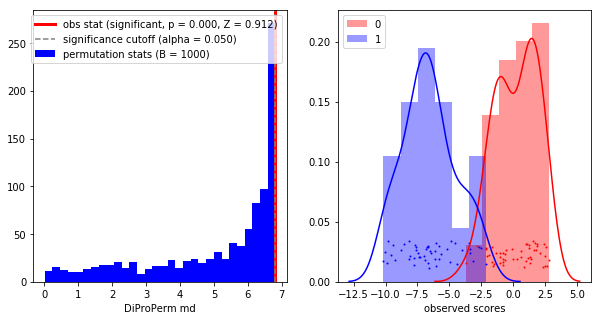

In [5]:

plt.figure(figsize=[10, 5])

# show histogram of separation statistics
plt.subplot(1, 2, 1)
dpp.plot_perm_sep_stats(stat='md')

# the observed scores
plt.subplot(1, 2, 2)
dpp.plot_observed_scores()

## custom linear classifiers
The `clf` argument can take a function which takes (X, y) data and returns scores (where scores = Xw, w = classification normal vector).

In [6]:
from diproperm.classifiers import get_training_fun
from sklearn.svm import LinearSVC

# clf fits an SVM, selecting C using 5 fold cross-validation, then returns the scores
# of the training data
clf = get_training_fun(clf=LinearSVC(max_iter=10000),  # max_iter set only to suppress annoying warning messages
                       param_grid={'C': [.0001, .001, .01, 1, 10, 100]},  # C grid to cross-validate over
                       metric='roc_auc', n_splits=5)

dpp = DiProPerm(B=1000, clf=clf)
dpp.fit(X, y)

# plt.figure(figsize=[17, 5])
# plt.subplot(1, 3, 1)
# dpp.hist('md')
# plt.subplot(1, 3, 2)
# dpp.hist('t')
# plt.subplot(1, 3, 3)
# dpp.hist('auc')

Two class DiProPerm

In [7]:
# the clf object above is a function which takes an X, y input,
# trains SVM using 5 fold cross-valdiation, then returns the
# sores of the training data
print(clf(X, y))

[ 0.94772043 -0.31910185]


In [8]:
# for details see diproperm.classifiers.py
print(clf.__doc__)


        Selects hyper-parameters using cross-validation. Then refits
        using the full data set and returns the classification scores.

        Parameters
        -----------
        X: array-like, shape (n_samples, n_features)
            The X data.

        y: array-like, shape (n_samples, )
            Class labels.

        Output
        -----

        w: array-like, shape (n_features, )
            Normalized classification vector.
        


## parallel processing

The permutation statistics can be sampled in parallel using sklearn.externals.joblib.Parallel

In [9]:
# sample DiProPerm not in parallel 
%time dpp = DiProPerm(B=10000).fit(X, y)

# sample permutation in parallel using all available cores
%time dpp = DiProPerm(B=10000, n_jobs=-1).fit(X, y)

CPU times: user 10.2 s, sys: 50.5 ms, total: 10.3 s
Wall time: 10.3 s
CPU times: user 11.6 s, sys: 207 ms, total: 11.8 s
Wall time: 15 s


## custom test statistics

The user can provide custom test statistics which are functions of the observed statistic and the permutation statistics. For example, suppose we want the "robust" Z statistic (i.e. median/mad) instead of the standard Z statistic.

In [10]:
from statsmodels.robust.scale import mad

def robust_Z(obs_stat, perm_samples):
    return (obs_stat - np.median(perm_samples))/mad(perm_samples)

# should be an interable where each entry is a tuple containing
# a string (naming the statistic) and a function which computes
# the statistic.
custom_test_stats = [('robust_Z', robust_Z)]

dpp = DiProPerm(custom_test_stats=custom_test_stats).fit(X, y)

# notice robust_Z is one of the keys of test_stats_
print(dpp.test_stats_['md'].keys()) 
print()
print('standard Z statistic', dpp.test_stats_['md']['Z'])
print('robust Z statistic', dpp.test_stats_['md']['robust_Z'])

dict_keys(['obs', 'pval', 'rejected', 'cutoff_val', 'Z', 'robust_Z'])

standard Z statistic 0.9801153787686847
robust Z statistic 0.7279206925976437


#### custom separation statistics

The user can provide custom separation statistics. For example, suppose we want the "median difference" statistics:

In [11]:
def median_difference(scores, y):
    y = np.array(y)
    classes = np.unique(y)
    assert len(classes) == 2
    s0 = scores[y == classes[0]]
    s1 = scores[y == classes[1]]
    return abs(np.median(s0) - np.median(s1))
    
    
custom_sep_stats = [('median_difference', median_difference)]

dpp = DiProPerm(custom_separation_stats=custom_sep_stats).fit(X, y)
dpp.test_stats_['median_difference']

TypeError: __init__() got an unexpected keyword argument 'custom_separation_stats'